In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./kaggle/input\Email-Enron.txt
./kaggle/input\bio-DM-LC\bio-DM-LC.txt
./kaggle/input\econ-wm1\econ-wm1.txt
./kaggle/input\fb-pages-food\fb-pages-food.edges
./kaggle/input\fb-pages-food\fb-pages-food.nodes
./kaggle/input\ia-enron-only\ia-enron-only.txt


In [2]:
import networkx as nx
import community
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import normalized_mutual_info_score


In [3]:
## Main Code

def utility(node_i,S, G):
    total_utility = 0
    k_i = G.degree[node_i]
    for node_j in S:
        if node_i != node_j:
            curr_edges = A[node_i][node_j]

            k_j = G.degree[node_j]
            m = G.number_of_edges()
            degree_prod = (k_i*k_j)/(2.0*m)

            indiv_utility = curr_edges - degree_prod
            total_utility += indiv_utility
    return total_utility


def internalCommunityEdges(nodes_list, community_label):
    internaledges = 0
    for node in nodes_list:
        p = len(np.where(S[[n for n in G.neighbors(node)]] == community_label)[0])
        #print(node)
        internaledges += p
    
    inter = internaledges/(2.0)
    return inter


def community_ext(nodes_list):
    unique_external_nodes = []
    total_sum = 0
    community_label = S[nodes_list[0]]
    total_connections = 0
    totalExternalNodeDegree = 0
    for nod in nodes_list:
        #neighbors of node in that community       
        for neig in G[nod]:
            # external node
            if S[neig] != S[nod]:
                if neig not in unique_external_nodes:
                    unique_external_nodes.append(neig)
                total_connections += 1
                
    communityDegree = len(unique_external_nodes)
    for externalNode in unique_external_nodes:
        totalExternalNodeDegree += G.degree(externalNode)
        
    
    totalCommunityEdges = totalEdges - internalCommunityEdges(nodes_list, community_label)
    modularityComm = total_connections - ((totalExternalNodeDegree*communityDegree)/(2.0 * totalCommunityEdges))
    modularityComm = modularityComm/(2.0 * totalCommunityEdges)
    return modularityComm


def join(node_i,S, G, lamda, probabilities):
    max_utility = []
    community_toJoin = []
    currentCommunity = S[node_i]
    currentCommunity_nodes_list = np.where(S == currentCommunity)[0]
    
    loss = utility(node_i, currentCommunity_nodes_list, G)
    #print(loss)
    for neighbor in G[node_i]:
        community_label = S[neighbor]
        community_toJoin.append(community_label)
        nodes_list = np.where(S == community_label)[0]
        gain = utility(node_i, nodes_list, G)
        
        community_label = S[neighbor]
#         print(community_label)
        #community_toJoin.append(community_label)
        same_community_nodes_list = np.where(S == community_label)[0]
        other = community_ext(same_community_nodes_list)
        val = lamda*(gain-loss) + (1-lamda)*(other)
        max_utility.append(val)
        #print(nodes_list)
    
    maximum_utility_val = max(max_utility)
    if(maximum_utility_val) >0:
        probabilities[node_i] *= (1-lamda)
    maxUtilityIndex = max_utility.index(maximum_utility_val)
    communityIndex = community_toJoin[maxUtilityIndex]
    #print(communityIndex)
    
    #update the community for node_i
    S[node_i] = communityIndex
    return S


from sklearn.metrics.cluster import normalized_mutual_info_score

def partitionModularity(mod_list,G):
    totalModularity = 0
    for node_i in range(G.number_of_nodes()):
        totalModularity += utility(node_i,np.where(mod_list==mod_list[node_i])[0],G)
    return (totalModularity/(G.number_of_edges()*2.0))

from tqdm.auto import tqdm

def communityDetect(S,G, nIter, LAMBDA = 1):
    total_nodes = G.number_of_nodes()
    i = 0
    prev_S = initial_S
    val = []
#   while(i<nIter):
    for _ in tqdm(range(nIter)):
#         print("Iteration No. : ", i+1)
        probab = np.array(probabilities)
        probab /= probab.sum()
        random_node = choice(nodesList, 1, p=probab)
        S = join(random_node[0], S, G, LAMBDA, probab)
        val.append(partitionModularity(S,G))
        prev_S = S      
#         i += 1
        
    return val, prev_S
        

# Bio DM-LC Dataset

In [4]:
import networkx as nx
import pandas as pd

l1 = []
l2 = []
file = open('./kaggle/input/bio-DM-LC/bio-DM-LC.txt')

for line in file:
    l1.append(int(line.split()[0]))
    l2.append(int(line.split()[1]))

df = pd.DataFrame()
df[1] = l1
df[2] = l2

G = nx.Graph()
G = nx.from_pandas_edgelist(df, 1, 2)

mapping  = {} 
i = 0
for node in G.nodes:
    mapping[node] = i
    i += 1
    
    
G=nx.relabel_nodes(G,mapping)

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 658
Number of edges: 1129
Average degree:   3.4316


In [5]:
part = community.best_partition(G)
community.modularity(part, G)

0.8137506952938122

In [6]:
pip install community

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached community-1.0.0b1-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [7]:
%%time

from random import choice
import random

totalEdges = G.number_of_edges()
totalNodes= G.number_of_nodes()
A = nx.to_numpy_array(G)
S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])

initial_S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])
nodesList = [node_k for node_k in range(G.number_of_nodes())]

from numpy.random import choice
probabilities = [float(1/(G.number_of_nodes()*1.0)) for i in range(G.number_of_nodes())]

value_lambda_point2 = communityDetect(S,G,nIter = 1000,LAMBDA = 0.2)

print('Partition Modularity = '+ str(partitionModularity(S,G)))

  0%|          | 0/1000 [00:00<?, ?it/s]

Partition Modularity = 0.40007147110441327
Wall time: 1min 47s


In [8]:
%%time

from random import choice
import random

totalEdges = G.number_of_edges()
totalNodes= G.number_of_nodes()
A = nx.to_numpy_array(G)
S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])
initial_S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])
nodesList = [node_k for node_k in range(G.number_of_nodes())]

from numpy.random import choice
probabilities = [float(1/(G.number_of_nodes()*1.0)) for i in range(G.number_of_nodes())]

value_lambda_point8 = communityDetect(S,G,nIter = 1000,LAMBDA = 0.8)

print('Partition Modularity = '+ str(partitionModularity(S, G)))

  0%|          | 0/1000 [00:00<?, ?it/s]

Partition Modularity = 0.42041641528869744
Wall time: 1min 39s


In [9]:
%%time

from random import choice
import random

totalEdges = G.number_of_edges()
totalNodes= G.number_of_nodes()
A = nx.to_numpy_array(G)
S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])
initial_S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])
nodesList = [node_k for node_k in range(G.number_of_nodes())]

from numpy.random import choice
probabilities = [float(1/(G.number_of_nodes()*1.0)) for i in range(G.number_of_nodes())]

value_lambda_1 = communityDetect(S,G,nIter = 1000,LAMBDA = 1)

print('Partition Modularity = '+ str(partitionModularity(S, G)))

  0%|          | 0/1000 [00:00<?, ?it/s]

Partition Modularity = 0.43909226205653185
Wall time: 1min 58s


D:\Application\anaconda3\envs\game_theory\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Application\anaconda3\envs\game_theory\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


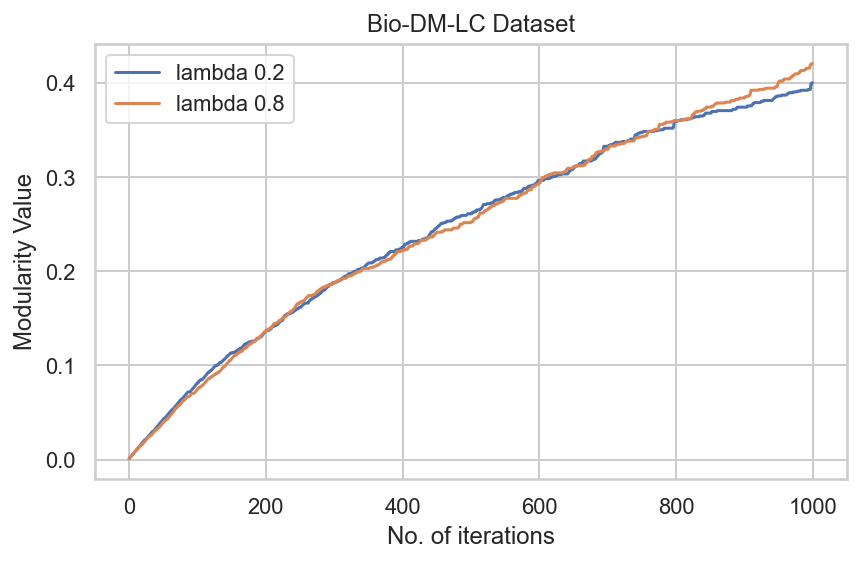

In [10]:
import seaborn as sns 

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set(style = 'whitegrid')
plt.title("Bio-DM-LC Dataset")
sns.lineplot([i for i in range(len(value_lambda_point2[0]))] , value_lambda_point2[0],  label="lambda 0.2")
sns.lineplot([i for i in range(len(value_lambda_point8[0]))] , value_lambda_point8[0],  label="lambda 0.8")
 
plt.xlabel("No. of iterations")
plt.ylabel("Modularity Value")
plt.legend() 
# plt.show()
plt.savefig("Bio-DM-LC_1.svg")

D:\Application\anaconda3\envs\game_theory\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\Application\anaconda3\envs\game_theory\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


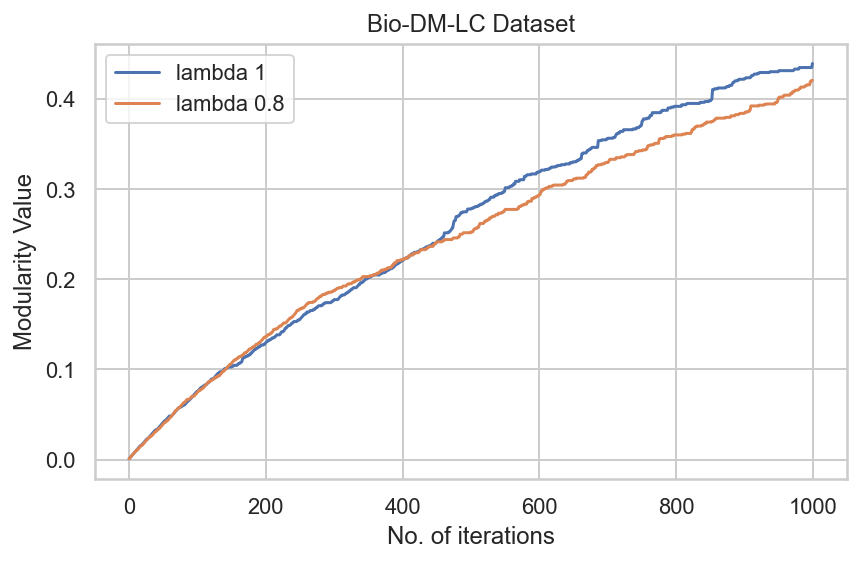

In [11]:
import seaborn as sns 

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set(style = 'whitegrid')
plt.title("Bio-DM-LC Dataset")
sns.lineplot([i for i in range(len(value_lambda_1[0]))] , value_lambda_1[0],  label="lambda 1")
sns.lineplot([i for i in range(len(value_lambda_point8[0]))] , value_lambda_point8[0],  label="lambda 0.8")
 
plt.xlabel("No. of iterations")
plt.ylabel("Modularity Value")
plt.legend() 
# plt.show()
plt.savefig("Bio-DM-LC_2.svg")

# Enron Dataset

In [12]:
import networkx as nx
import pandas as pd

l1 = []
l2 = []
file = open('../input/enrondata/ia-enron-only.txt')

for line in file:
    l1.append(int(line.split()[0]))
    l2.append(int(line.split()[1]))

df = pd.DataFrame()
df[1] = l1
df[2] = l2

G = nx.Graph()
G = nx.from_pandas_edgelist(df, 1, 2)

mapping  = {} 
i = 0
for node in G.nodes:
    mapping[node] = i
    i += 1
    
    
G=nx.relabel_nodes(G,mapping)

print(nx.info(G))

FileNotFoundError: [Errno 2] No such file or directory: '../input/enrondata/ia-enron-only.txt'

In [ ]:
part = community.best_partition(G)
community.modularity(part, G)

In [ ]:
from random import choice
import random
import numpy as np

totalEdges = G.number_of_edges()
totalNodes= G.number_of_nodes()
A = nx.to_numpy_array(G)
S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])

initial_S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])
nodesList = [node_k for node_k in range(G.number_of_nodes())]

from numpy.random import choice
probabilities = [float(1/(G.number_of_nodes()*1.0)) for i in range(G.number_of_nodes())]

value_lambda_point2 = communityDetect(S,G,nIter = 1000,LAMBDA = 0.2)

print('Partition Modularity = '+ str(partitionModularity(S,G)))

In [ ]:
from random import choice
import random

totalEdges = G.number_of_edges()
totalNodes= G.number_of_nodes()
A = nx.to_numpy_array(G)
S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])

initial_S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])
nodesList = [node_k for node_k in range(G.number_of_nodes())]

from numpy.random import choice
probabilities = [float(1/(G.number_of_nodes()*1.0)) for i in range(G.number_of_nodes())]

value_lambda_point8 = communityDetect(S,G,nIter = 1000,LAMBDA = 0.8)

print('Partition Modularity = '+ str(partitionModularity(S,G)))

In [ ]:
from random import choice
import random

totalEdges = G.number_of_edges()
totalNodes= G.number_of_nodes()
A = nx.to_numpy_array(G)
S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])

initial_S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])
nodesList = [node_k for node_k in range(G.number_of_nodes())]

from numpy.random import choice
probabilities = [float(1/(G.number_of_nodes()*1.0)) for i in range(G.number_of_nodes())]

value_lambda_1 = communityDetect(S,G,nIter = 1000,LAMBDA = 1)

print('Partition Modularity = '+ str(partitionModularity(S,G)))

In [ ]:
import seaborn as sns 

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set(style = 'whitegrid')
plt.title("Enron Dataset")
sns.lineplot([i for i in range(len(value_lambda_point2[0]))] , value_lambda_point2[0],  label="lambda 0.2")
sns.lineplot([i for i in range(len(value_lambda_point8[0]))] , value_lambda_point8[0],  label="lambda 0.8")
 
plt.xlabel("No. of iterations")
plt.ylabel("Modularity Value")
plt.legend() 
# plt.show()
plt.savefig("Enron_1.svg")

In [ ]:
import seaborn as sns 

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set(style = 'whitegrid')
plt.title("Enron Dataset")
sns.lineplot([i for i in range(len(value_lambda_1[0]))] , value_lambda_1[0],  label="lambda 1")
sns.lineplot([i for i in range(len(value_lambda_point8[0]))] , value_lambda_point8[0],  label="lambda 0.8")
 
plt.xlabel("No. of iterations")
plt.ylabel("Modularity Value")
plt.legend() 
# plt.show()
plt.savefig("Enron_2.svg")

# Econ wm1 dataset

In [ ]:
import networkx as nx
import pandas as pd

l1 = []
l2 = []
file = open('../input/econwm1/econ-wm1.txt')

for line in file:
    l1.append(int(line.split()[0]))
    l2.append(int(line.split()[1]))

df = pd.DataFrame()
df[1] = l1
df[2] = l2

G = nx.Graph()
G = nx.from_pandas_edgelist(df, 1, 2)

mapping  = {} 
i = 0
for node in G.nodes:
    mapping[node] = i
    i += 1
    
    
G=nx.relabel_nodes(G,mapping)

print(nx.info(G))

In [ ]:
part = community.best_partition(G)
community.modularity(part, G)

In [ ]:
from random import choice
import random
import numpy as np

totalEdges = G.number_of_edges()
totalNodes= G.number_of_nodes()
A = nx.to_numpy_array(G)
S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])

initial_S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])
nodesList = [node_k for node_k in range(G.number_of_nodes())]

from numpy.random import choice
probabilities = [float(1/(G.number_of_nodes()*1.0)) for i in range(G.number_of_nodes())]

value_lambda_point2 = communityDetect(S,G,nIter = 600,LAMBDA = 0.2)

print('Partition Modularity = '+ str(partitionModularity(S,G)))

In [ ]:
%%time
from random import choice
import random

totalEdges = G.number_of_edges()
totalNodes= G.number_of_nodes()
A = nx.to_numpy_array(G)
S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])

initial_S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])
nodesList = [node_k for node_k in range(G.number_of_nodes())]

from numpy.random import choice
probabilities = [float(1/(G.number_of_nodes()*1.0)) for i in range(G.number_of_nodes())]

value_lambda_point8 = communityDetect(S,G,nIter = 600,LAMBDA = 0.8)

print('Partition Modularity = '+ str(partitionModularity(S,G)))

In [ ]:
from random import choice
import random

totalEdges = G.number_of_edges()
totalNodes= G.number_of_nodes()
A = nx.to_numpy_array(G)
S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])

initial_S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])
nodesList = [node_k for node_k in range(G.number_of_nodes())]

from numpy.random import choice
probabilities = [float(1/(G.number_of_nodes()*1.0)) for i in range(G.number_of_nodes())]

value_lambda_1 = communityDetect(S,G,nIter = 600,LAMBDA = 1)

print('Partition Modularity = '+ str(partitionModularity(S,G)))

In [ ]:
import seaborn as sns 

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set(style = 'whitegrid')
plt.title("Econ-wm1 Dataset")
sns.lineplot([i for i in range(len(value_lambda_point2[0]))] , value_lambda_point2[0],  label="lambda 0.2")
sns.lineplot([i for i in range(len(value_lambda_point8[0]))] , value_lambda_point8[0],  label="lambda 0.8")
 
plt.xlabel("No. of iterations")
plt.ylabel("Modularity Value")
plt.legend() 
# plt.show()
plt.savefig("Econ_1.svg")

In [ ]:
import seaborn as sns 

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set(style = 'whitegrid')
plt.title("Econ-wm1 Dataset")
sns.lineplot([i for i in range(len(value_lambda_1[0]))] , value_lambda_1[0],  label="lambda 1")
sns.lineplot([i for i in range(len(value_lambda_point8[0]))] , value_lambda_point8[0],  label="lambda 0.8")
 
plt.xlabel("No. of iterations")
plt.ylabel("Modularity Value")
plt.legend() 
# plt.show()
plt.savefig("Econ_2.svg")

# Fb Food Dataset

In [ ]:
import networkx as nx
import pandas as pd

l1 = []
l2 = []
file = open('../input/fbpagesfood/fb-pages-food.txt')

for line in file:
    l1.append(int(line.split(',')[0]))
    l2.append(int(line.split(',')[1]))

df = pd.DataFrame()
df[1] = l1
df[2] = l2

G = nx.Graph()
G = nx.from_pandas_edgelist(df, 1, 2)

mapping  = {} 
i = 0
for node in G.nodes:
    mapping[node] = i
    i += 1
    
    
G=nx.relabel_nodes(G,mapping)

print(nx.info(G))

In [ ]:
part = community.best_partition(G)
community.modularity(part, G)

In [ ]:
from random import choice
import random
import numpy as np

totalEdges = G.number_of_edges()
totalNodes= G.number_of_nodes()
A = nx.to_numpy_array(G)
S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])

initial_S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])
nodesList = [node_k for node_k in range(G.number_of_nodes())]

from numpy.random import choice
probabilities = [float(1/(G.number_of_nodes()*1.0)) for i in range(G.number_of_nodes())]

value_lambda_point2 = communityDetect(S,G,nIter = 1000,LAMBDA = 0.2)

print('Partition Modularity = '+ str(partitionModularity(S,G)))

In [ ]:
%%time
from random import choice
import random

totalEdges = G.number_of_edges()
totalNodes= G.number_of_nodes()
A = nx.to_numpy_array(G)
S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])

initial_S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])
nodesList = [node_k for node_k in range(G.number_of_nodes())]

from numpy.random import choice
probabilities = [float(1/(G.number_of_nodes()*1.0)) for i in range(G.number_of_nodes())]

value_lambda_point8 = communityDetect(S,G,nIter = 1000,LAMBDA = 0.8)

print('Partition Modularity = '+ str(partitionModularity(S,G)))

In [ ]:
from random import choice
import random

totalEdges = G.number_of_edges()
totalNodes= G.number_of_nodes()
A = nx.to_numpy_array(G)
S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])

initial_S = np.array([("C" + str(i)) for i in range(G.number_of_nodes())])
nodesList = [node_k for node_k in range(G.number_of_nodes())]

from numpy.random import choice
probabilities = [float(1/(G.number_of_nodes()*1.0)) for i in range(G.number_of_nodes())]

value_lambda_1 = communityDetect(S,G,nIter = 1000,LAMBDA = 1)

print('Partition Modularity = '+ str(partitionModularity(S,G)))

In [ ]:
import seaborn as sns 

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set(style = 'whitegrid')
plt.title("Fb-food Dataset")
sns.lineplot([i for i in range(len(value_lambda_point2[0]))] , value_lambda_point2[0],  label="lambda 0.2")
sns.lineplot([i for i in range(len(value_lambda_point8[0]))] , value_lambda_point8[0],  label="lambda 0.8")
 
plt.xlabel("No. of iterations")
plt.ylabel("Modularity Value")
plt.legend() 
# plt.show()
plt.savefig("Fb-food_1.svg")

In [ ]:
import seaborn as sns 

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set(style = 'whitegrid')
plt.title("Fb-food Dataset")
sns.lineplot([i for i in range(len(value_lambda_1[0]))] , value_lambda_1[0],  label="lambda 1")
sns.lineplot([i for i in range(len(value_lambda_point8[0]))] , value_lambda_point8[0],  label="lambda 0.8")
 
plt.xlabel("No. of iterations")
plt.ylabel("Modularity Value")
plt.legend() 
# plt.show()
plt.savefig("Fb-food_2.svg")